## 15.1 Exploring the recurrent neural network

A recurrent neural network (RNN) is a deep learning architecture especially adapted to processing sequences of data. It denotes a set of networks that share a similar architecture: long short-term memory (LSTM) and gated recurrent unit (GRU) are subtypes of RNNs. In this chapter, we’ll solely focus on the LSTM architecture.

To understand the inner workings of an RNN, we’ll start with figure 15.1, which shows a compact illustration of an RNN. Just like in a deep neural network (DNN), we have an input, denoted as $x_t$, and an output, denoted as $y_t$. Here $x_t$ is an element of a sequence. When it is fed to the RNN, it computes a hidden state, denoted as $h_t$. This hidden state acts as memory. It is computed for each element of the sequence and fed back to the RNN as an input. That way, the network effectively uses past information computed for previous elements of the sequence to inform the output for the next element of the sequence.

Figure 15.2 shows an expanded illustration of an RNN. You can see how the hidden state is first computed at t = 0 and then is updated and passed on as each element of the sequence is processed. This is how the RNN effectively replicates the concept of memory and uses past information to produce a new output.

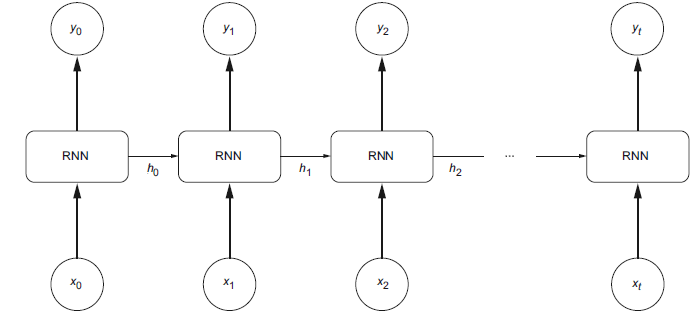

However, the basic RNNs that we have examined come with a drawback: they suffer from short-term memory due to the vanishing gradient. The gradient is simply the function that tells the network how to change the weights. If the change in gradient is large, the weights change by a large magnitude. On the other hand, if the change in gradient is small, the weights do not change significantly. The vanishing gradient problem refers to what happens when the change in gradient becomes very small, sometimes close to 0. This in turn means that the weights of the network do not get updated, and the network stops learning.

In practice, this means the RNN forgets about past information that is far away in the sequence. It therefore suffers from a short-term memory. For example, if an RNN is processing 24 hours of hourly data, the points at hours 9, 10, and 11 might still impact the output at hour 12, but any point prior to hour 9 might not contribute at all to the network’s learning, because the gradient gets very small for those early data points.

Therefore, we must find a way to retain the importance of past information in our network. This brings us to the long short-term memory (LSTM) architecture, which uses the cell state as an additional way of keeping past information in memory for a long time.

## 15.2 Examining the LSTM architecture

The long short-term memory (LSTM) architecture adds a cell state to the RNN architecture to avoid the vanishing gradient problem, where past information ceases to impact the learning of the network. This allows the network to keep past information in memory for a longer time.

The LSTM architecture is shown in figure 15.3, and you can see that it is more complex than the basic RNN architecture. You’ll notice the addition of the cell state, denoted as C. This cell state is what allows the network to keep past information in the network for a longer time, thus resolving the vanishing gradient problem. Note that this is unique to the LSTM architecture. We still have an element of a sequence being processed, shown as $x_t$, and a hidden state is also computed, denoted as $h_t$. In this case, both the cell state $C_t$ and the hidden $h_t$ are passed on to the next element of the sequence, making sure that past information is used as an input for the next element in the sequence being processed.

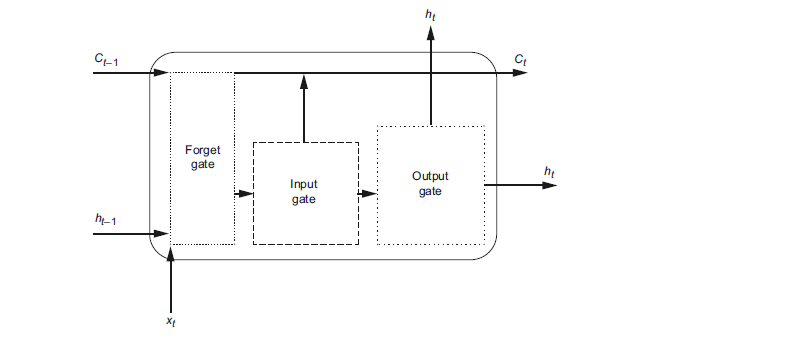

You’ll also notice the presence of three gates: the forget gate, the input gate, and the output gate. Each has its specific function in the LSTM, so let’s explore each one in detail.

### 15.2.1 The forget gate

The forget gate is the first gate in an LSTM cell. Its role is to determine what information, from both the past values and the current value of the sequence, should be forgotten or kept in the network.

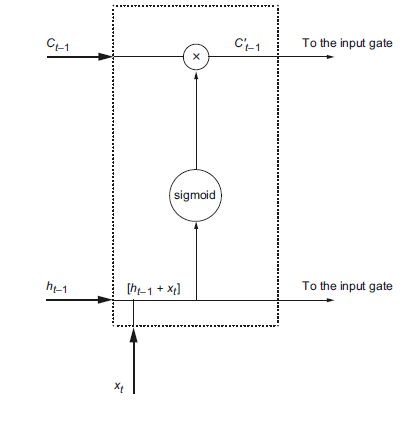

Looking at figure 15.4, we can see how the different inputs flow through the forget gate. First, the past hidden state  and the present value of a sequence $x_t$ are fed into the forget gate. Recall that the past hidden state carries information from past values. Then, $h_{t-1}$ and $x_t$ are combined and duplicated. One copy goes straight to the input gate, which we’ll study in the next section. The other copy is sent through a sigmoid activation function, which is expressed as equation 15.1 and is shown in
figure 15.5.

$f(x) = \frac{1}{1 - e^{-x}}$

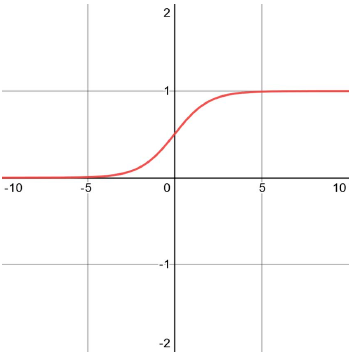

The sigmoid function determines which information to keep or to forget. That output is then combined with the previous cell state $C_{t-1}$ using pointwise multiplication. This results in an updated cell state that we call $C'_{t-1}$.

Once this is done, two things are sent to the input gate: an updated cell state, and a copy of the combination of the past hidden state and the current element of the sequence.



### 15.2.2 The input gate

Once information has passed through the forget gate, it proceeds to the input gate. This is the step where the network determines which information is relevant from the current element of the sequence. The cell state is updated again here, resulting in the final cell state.

Again, let’s zoom in on the input gate using figure 15.6. The combination of the past hidden state and the current element of a sequence $[h_{t-1} + x_t]$ coming from the forget gate is fed into the input gate and it is again duplicated. One copy goes out the input gate toward the output gate, which we’ll explore in the next section. Another copy is sent through the sigmoid activation function to determine if the information will be kept or forgotten. Another copy is sent through the hyperbolic tangent (tanh) function, which is shown in figure 15.7.

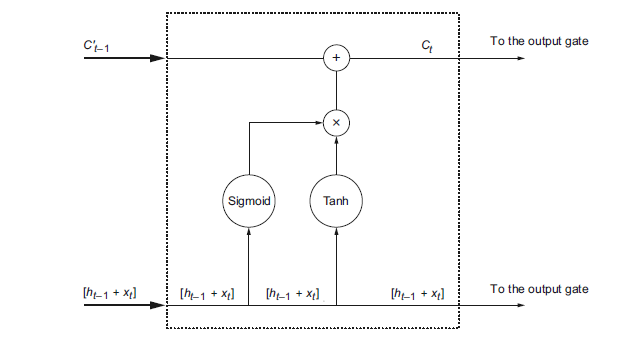


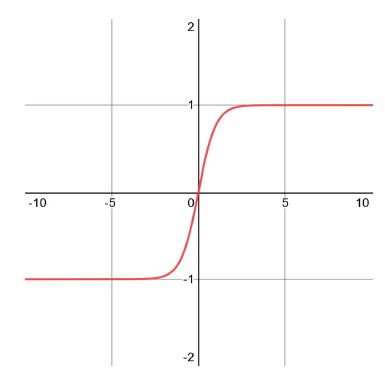

The outputs of the sigmoid and tanh functions are combined using pointwise multiplication, and the result is combined with the updated cell state coming from the forget gate $C'_{t-1}$ using pointwise addition. This operation generates the final cell state $C_t$.

Therefore, it is in the input gate that we add information from the current element in the sequence to the long memory of the network. This newly updated cell state is then sent to the output gate.

### 15.2.3 The output gate

Information has now passed from the forget gate to the input gate, and now it arrives at the output gate. It is in this gate that past information contained in the network’s memory, represented by the cell state $C_t$, is finally used to process the current element of the sequence. This is also where the network either outputs a result to the output layer or computes new information to be sent to the processing of the next element in the sequence.

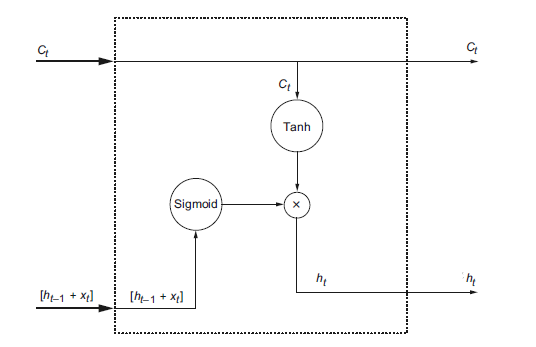

In figure 15.8 the past hidden state and current element of a sequence are sent through the sigmoid function. In parallel, the cell state goes through the tanh function.

The resulting values from the tanh and sigmoid functions are then combined using pointwise multiplication, generating an updated hidden state $h_t$. This is the step where past information, represented by the cell state $C_t$, is used to process the information of the present element of the sequence.

The current hidden state is then sent out of the output gate. This will either be sent to the output layer of the network or to the next LSTM neuron treating the next element of the sequence. The same applies for the cell state $C_t$.

In summary, the forget gate determines which information from the past is kept or discarded. The input gate determines which information from the current step is kept to update the network’s memory or is discarded. Finally, the output gate uses the information from the past stored in the network’s memory to process the current element of a sequence.

Having examined the inner workings of the LSTM architecture, we can now implement it for our interstate traffic dataset.

## 15.3 Implementing the LSTM architecture

We’ll now implement the LSTM architecture for the interstate traffic dataset we have been working with since chapter 12. Recall that the main target of our scenario is the traffic volume. For the multi-output model, the targets are traffic volume and temperature.

We’ll implement LSTM as a single-step model, a multi-step model, and a multioutput model. The single-step model will predict the traffic volume for the next timestep only, the multi-step model will predict the traffic volume for the next 24 hours, and the multi-output model will predict the temperature and traffic volume for the next timestep.

Make sure you have the DataWindow class and the compile_and_fit function (from chapters 13 and 14) in your notebook or Python script, as we’ll use these pieces of code to create windows of data and train the LSTM model.

The other prerequisite is to read the training set, the validation set, and the test set, so let’s do that right now:

In [2]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

print(tf.__version__)

tf.random.set_seed(42)
np.random.seed(42)

train_df = pd.read_csv('./train.csv', index_col=0)
val_df = pd.read_csv('./val.csv', index_col=0)
test_df = pd.read_csv('./test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)


2022-10-07 19:56:19.528876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 19:56:19.697892: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-07 19:56:19.697919: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-07 19:56:19.776324: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-07 19:56:20.948154: W tensorflow/stream_executor/platform/de

2.10.0
(33742, 8) (9641, 8) (4821, 8)


### 15.3.1 Implementing an LSTM as a single-step model

We’ll start by implementing the LSTM architecture as a single-step model. In this case, we’ll use 24 hours of data as an input to predict the next timestep. That way, there is a sequence of time that can be processed by the LSTM, allowing us to leverage past information to make a future prediction.

First we need to create a data window to train the model. This will be a wide window, with 24 hours of data as input. For plotting purposes, the label_width is also 24, so that we can compare the predictions to the actual values over 24 timesteps. Note that this is still a single-step model, so over 24 hours the model will only predict one timestep at a time, just like a rolling forecast.

In [3]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result


In [4]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

column_indices = {name: i for i, name in enumerate(train_df.columns)}

In [5]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

Then we need to define our LSTM model in Keras. Again we’ll use the Sequential model to allow us to stack different layers in our network. Keras conveniently comes with the LSTM layer, which implements an LSTM. We’ll set return_sequences to True, as this signals Keras to use past information from the sequence, in the form of the hidden state and cell state, which we covered earlier. Finally, we’ll define the output layer, which is simply a Dense layer with one unit because we are forecasting the traffic volume only.

In [6]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance = {}
performance = {}

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

2022-10-07 20:07:02.160033: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-07 20:07:02.160085: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-07 20:07:02.160112: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (deedevelopment): /proc/driver/nvidia/version does not exist
2022-10-07 20:07:02.160435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
1054/1054 [==============================] - 21s 17ms/step - loss: 0.0145 - mean_absolute_error: 0.0810 - val_loss: 0.0054 - val_mean_absolute_error: 0.0530
Epoch 2/50
1054/1054 [==============================] - 17s 16ms/step - loss: 0.0073 - mean_absolute_error: 0.0564 - val_loss: 0.0043 - val_mean_absolute_error: 0.0469
Epoch 3/50
1054/1054 [==============================] - 17s 17ms/step - loss: 0.0064 - mean_absolute_error: 0.0518 - val_loss: 0.0037 - val_mean_absolute_error: 0.0436
Epoch 4/50
1054/1054 [==============================] - 18s 17ms/step - loss: 0.0058 - mean_absolute_error: 0.0491 - val_loss: 0.0034 - val_mean_absolute_error: 0.0415
Epoch 5/50
1054/1054 [==============================] - 18s 17ms/step - loss: 0.0053 - mean_absolute_error: 0.0472 - val_loss: 0.0031 - val_mean_absolute_error: 0.0401
Epoch 6/50
1054/1054 [==============================] - 18s 17ms/step - loss: 0.0050 - mean_absolute_error: 0.0458 - val_loss: 0.0031 - val_mean_absolute_error:

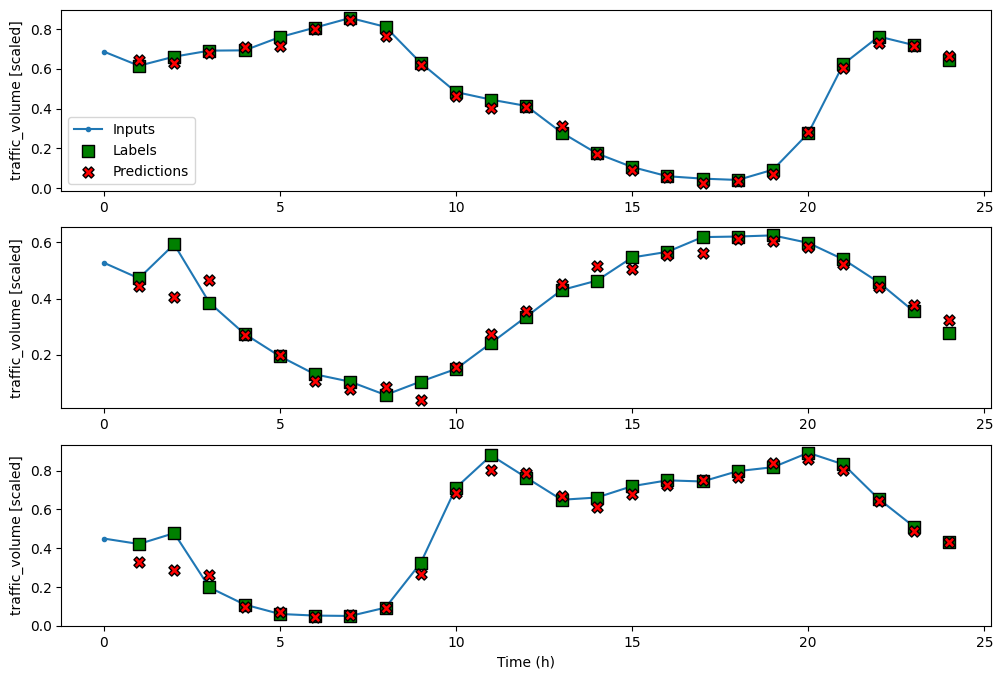

In [7]:
wide_window.plot(lstm_model)

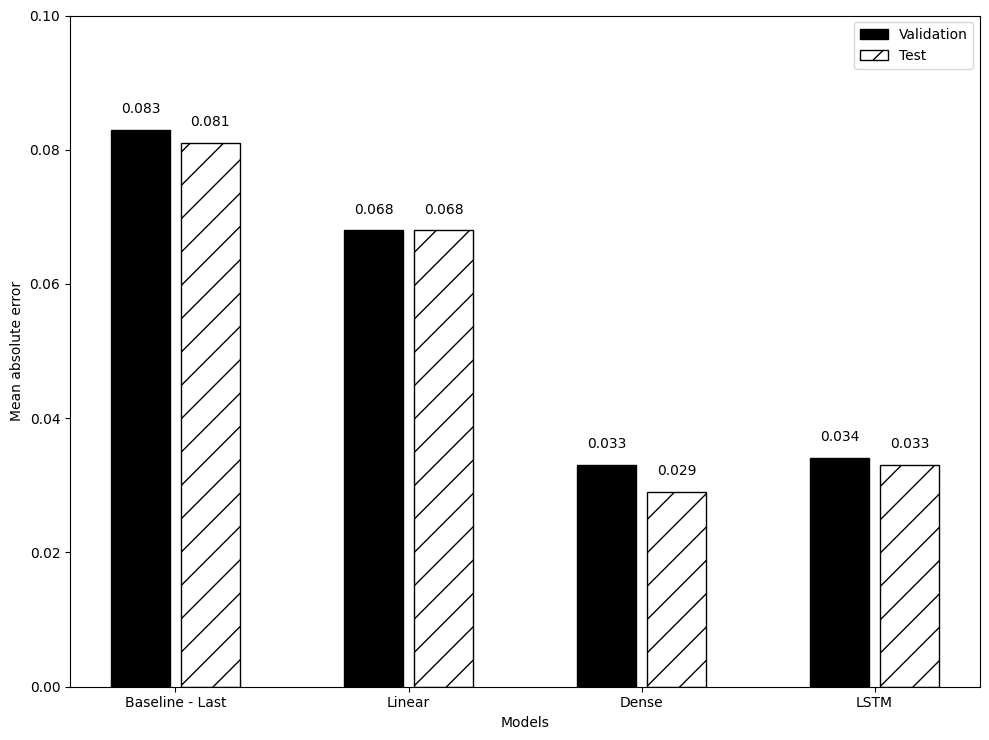

In [8]:
# Values obtained from chapter 14

mae_val = [0.083, 0.068, 0.033]
mae_test = [0.081, 0.068, 0.029]

mae_val.append(val_performance['LSTM'][1])
mae_test.append(performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

### 15.3.2 Implementing an LSTM as a multi-step model

We’ll move on to implementing the LSTM architecture as a multi-step model. In this case, we wish to predict traffic volume for next 24 hours, using an input window of 24 hours.

First, we’ll define the time window to feed our model. The input_width and label_width are both 24, since we want to input 24 hours of data and evaluate the predictions on 24 hours of data as well. This time the shift is also 24, specifying that the model must output predictions for the next 24 hours in a single shot.


In [9]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

Next, we’ll define our model in Keras. From chapter 14, you might recall that the process of defining the multi-step model and single-step model was exactly the same. The 

In [10]:
# Values obtained from chapter 14

ms_mae_val = [0.352, 0.347, 0.088, 0.078]
ms_mae_test = [0.347, 0.341, 0.076, 0.064]

In [11]:
ms_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_lstm_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.val)
ms_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
1053/1053 [==============================] - 22s 18ms/step - loss: 0.0685 - mean_absolute_error: 0.2175 - val_loss: 0.0552 - val_mean_absolute_error: 0.1940
Epoch 2/50
1053/1053 [==============================] - 18s 17ms/step - loss: 0.0598 - mean_absolute_error: 0.2014 - val_loss: 0.0535 - val_mean_absolute_error: 0.1910
Epoch 3/50
1053/1053 [==============================] - 18s 17ms/step - loss: 0.0590 - mean_absolute_error: 0.1989 - val_loss: 0.0531 - val_mean_absolute_error: 0.1913
Epoch 4/50
1053/1053 [==============================] - 18s 17ms/step - loss: 0.0584 - mean_absolute_error: 0.1976 - val_loss: 0.0528 - val_mean_absolute_error: 0.1886
Epoch 5/50
1053/1053 [==============================] - 18s 17ms/step - loss: 0.0577 - mean_absolute_error: 0.1960 - val_loss: 0.0517 - val_mean_absolute_error: 0.1851
Epoch 6/50
1053/1053 [==============================] - 18s 17ms/step - loss: 0.0572 - mean_absolute_error: 0.1947 - val_loss: 0.0516 - val_mean_absolute_error:

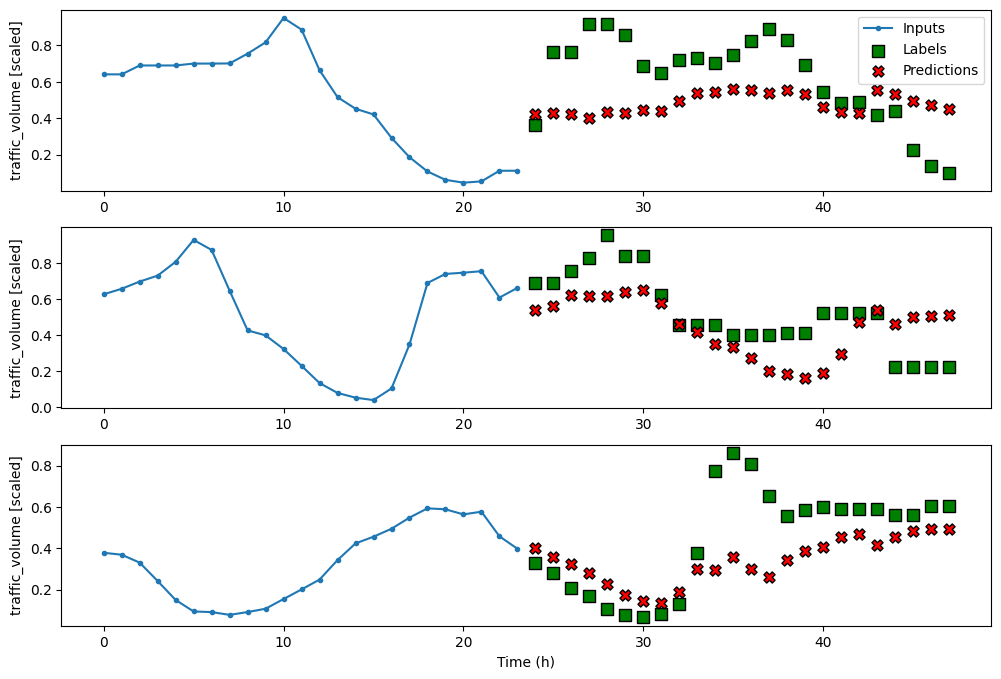

In [12]:
multi_window.plot(ms_lstm_model)

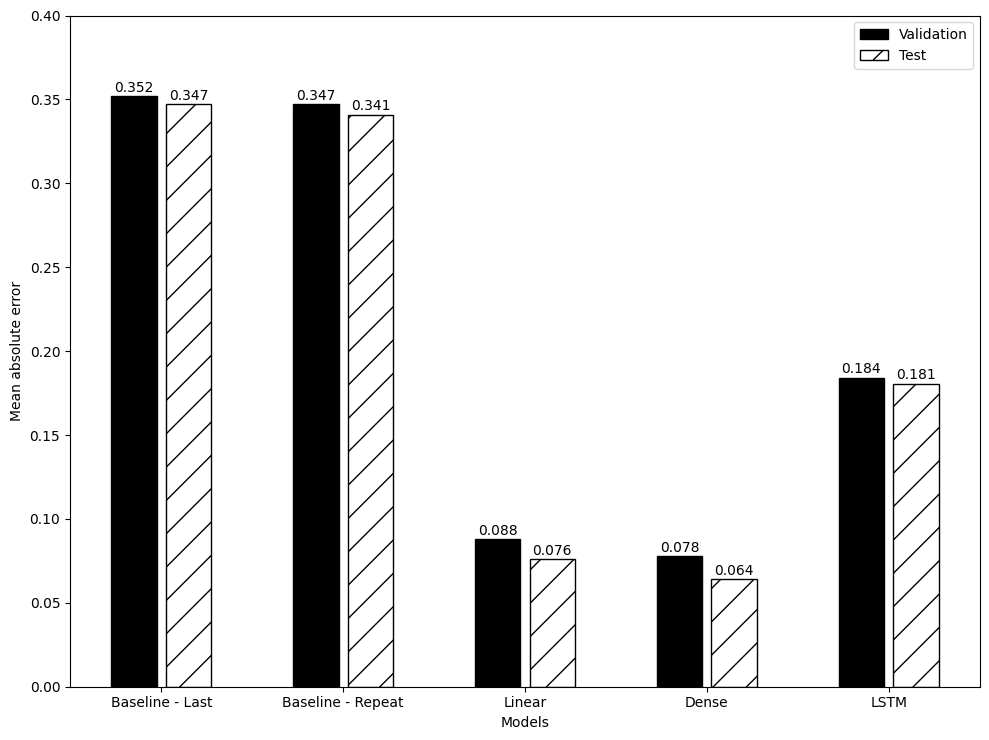

In [13]:
ms_mae_val.append(ms_val_performance['LSTM'][1])
ms_mae_test.append(ms_performance['LSTM'][1])

x = np.arange(5)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()


In [14]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])
# Values from chapter 14

mo_mae_val = [0.048, 0.039, 0.023]
mo_mae_test = [0.047, 0.036, 0.020]

mo_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units = 2)
])

history = compile_and_fit(mo_lstm_model, mo_wide_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
mo_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test, verbose=0)

Epoch 1/50
1054/1054 [==============================] - 23s 18ms/step - loss: 0.0160 - mean_absolute_error: 0.0709 - val_loss: 0.0033 - val_mean_absolute_error: 0.0380
Epoch 2/50
1054/1054 [==============================] - 19s 18ms/step - loss: 0.0042 - mean_absolute_error: 0.0363 - val_loss: 0.0025 - val_mean_absolute_error: 0.0301
Epoch 3/50
1054/1054 [==============================] - 23s 21ms/step - loss: 0.0037 - mean_absolute_error: 0.0327 - val_loss: 0.0022 - val_mean_absolute_error: 0.0278
Epoch 4/50
1054/1054 [==============================] - 19s 18ms/step - loss: 0.0033 - mean_absolute_error: 0.0307 - val_loss: 0.0019 - val_mean_absolute_error: 0.0265
Epoch 5/50
1054/1054 [==============================] - 19s 18ms/step - loss: 0.0030 - mean_absolute_error: 0.0292 - val_loss: 0.0018 - val_mean_absolute_error: 0.0248
Epoch 6/50
1054/1054 [==============================] - 19s 18ms/step - loss: 0.0028 - mean_absolute_error: 0.0279 - val_loss: 0.0017 - val_mean_absolute_error:

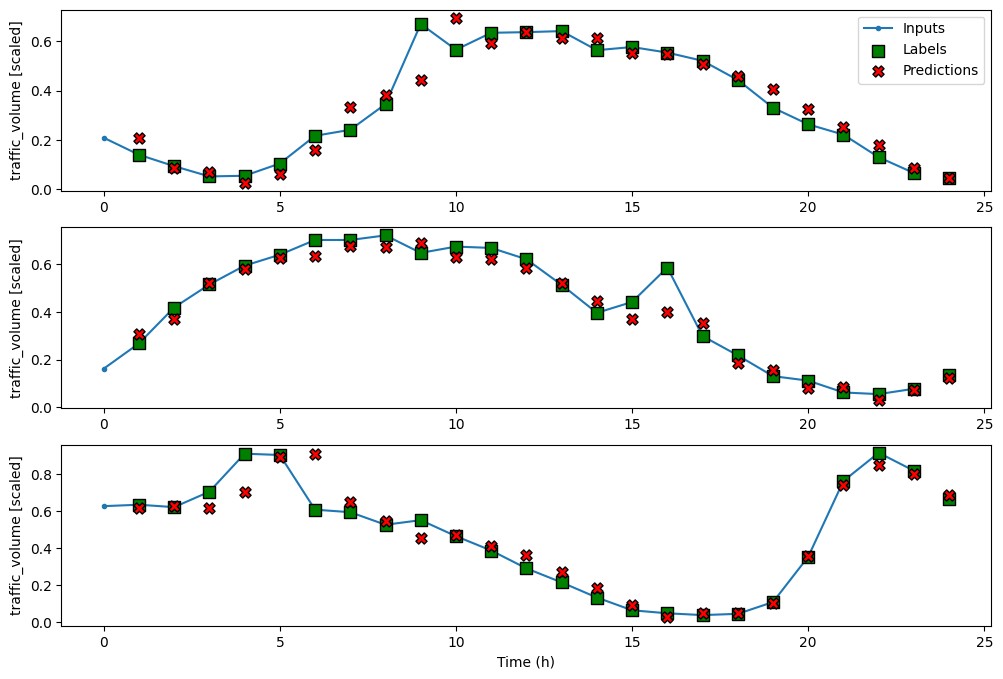

In [15]:
mo_wide_window.plot(mo_lstm_model)

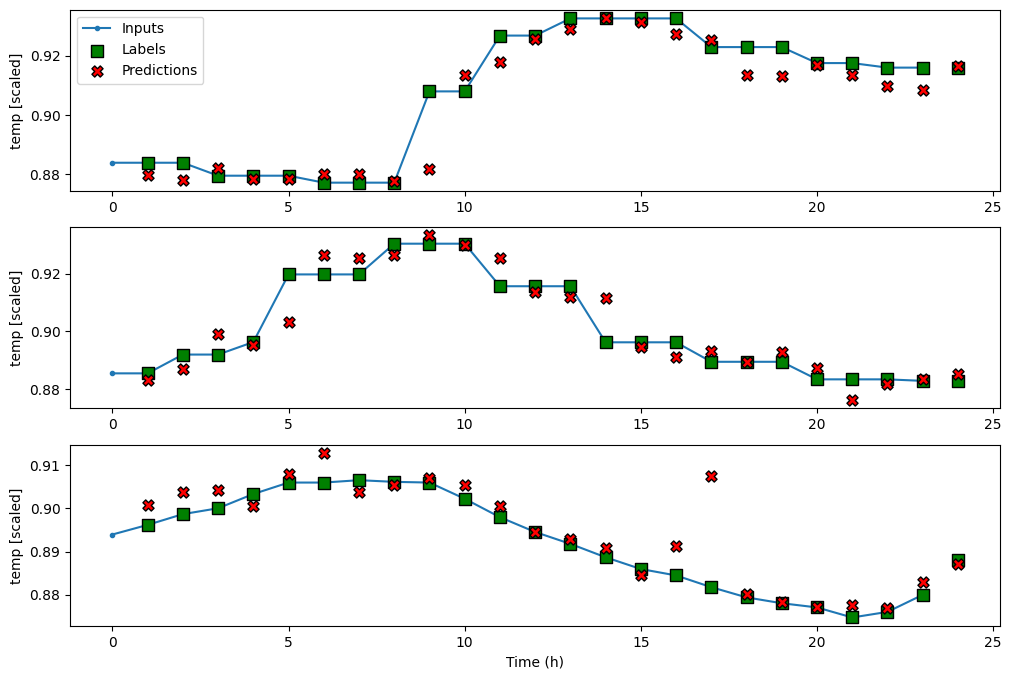

In [16]:
mo_wide_window.plot(model=mo_lstm_model, plot_col='temp')

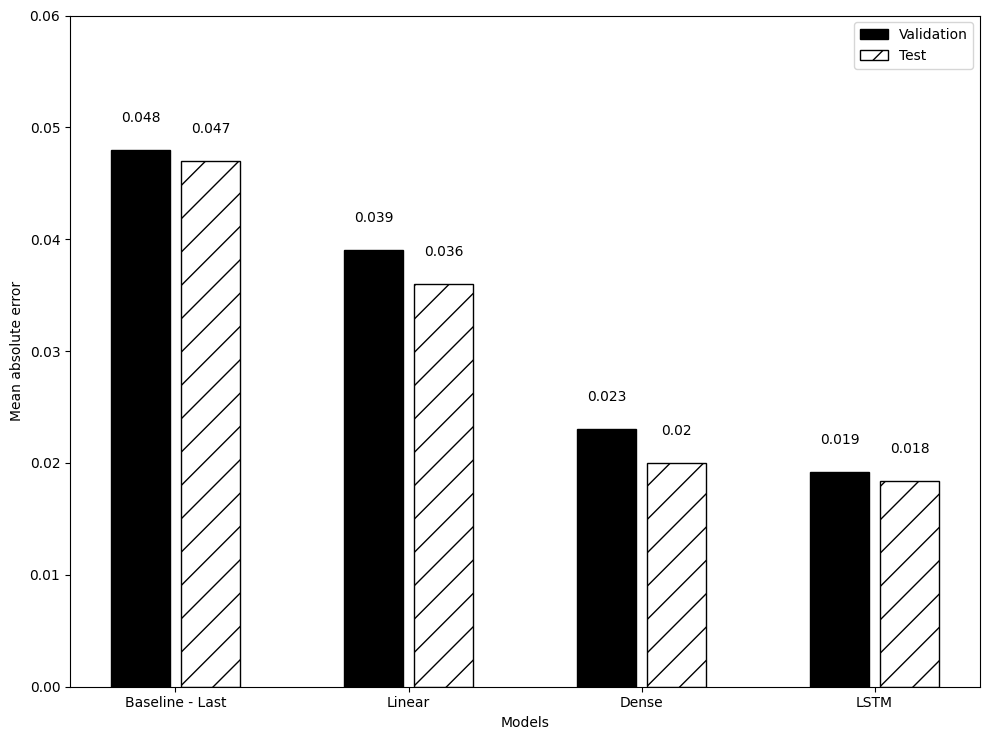

In [17]:
mo_mae_val.append(mo_val_performance['LSTM'][1])
mo_mae_test.append(mo_performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()